## Nanopore TXN elongation model
Author: Robert Ietswaart, 20220818  
License: BSD2.  
Load modules j3dl and activate virtual environment using j4RNAdecay on O2.
Python v3.7.4, pytorch v1.4 

For Erik's project: perform nascent RNA modelling based on Nanopore 3' end sequencing.

source file: `Nanopore_RNA_model.ipynb`

`*_mito_read_to_transcript_mapping_no_spliced_reads.txt`
KC: The only reads that are filtered out in this file are those that show "splicing" events (e.g. the read starts in one gene, skips a bunch of genes and ends in another gene), which are likely alignment artifacts since there is no splicing in mitochondria

In [1]:
import os
import copy
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
from gtfparse import read_gtf
import seaborn as sns
from scipy.optimize import least_squares
from lmfit import minimize, Parameters

import fit
# import new_total_ratio as ntr
# import aic

In [2]:
path = os.path.join('/n','groups','churchman','ri23','RNAdecay','TXN_model')

nano_reps = ['SEM2', 'SEM3']
deg_reps = ['TL3', 'TL4']

#load nanopore data
nano = dict()
genes = dict()
for r in nano_reps:
    filename = r + '_read_ends_coordinates.txt'
    nano[r] = pd.read_csv(os.path.join(path,'results_files',filename), sep='\t') 
    filename = r + '_mito_read_to_transcript_mapping_no_spliced_reads.txt'
    genes[r] = pd.read_csv(os.path.join(path,'results_files', filename), sep='\t') 
    
    
nano['merge'] = pd.concat([nano[nano_reps[0]], nano[nano_reps[1]]], ignore_index=True)
genes['merge'] = pd.concat([genes[nano_reps[0]], genes[nano_reps[1]]], ignore_index=True)

#load degradation rates
deg_rate = dict()
mapper = {'Fit1 (Ka)':'k', 'Gene':'symbol'}
for r in deg_reps:
    filename = r + '_MT_t5MTMMinformed6_modeAll_PcMTnorRNA_FracNew_halflives_corr_1592min.txt'
    deg_rate[r] = pd.read_csv(os.path.join(path, filename), sep='\t') 
    deg_rate[r].rename(mapper=mapper, axis=1, inplace=True)
deg_rate['mean'] = deg_rate[deg_reps[0]].drop(['Half Life', 'Normalized Half-Life'],axis=1)

#Drop MT-RNR1 because it was depleted using TLseq library prep
idx = deg_rate['mean'][deg_rate['mean']['symbol']=='MT-RNR1'].index
deg_rate['mean'].drop(idx,inplace=True)

deg_rate['mean']['k'] = np.sqrt(deg_rate[deg_reps[0]]['k'] *  deg_rate[deg_reps[1]]['k'])


filename = 'Hela_h_MT_MTmod.gtf'
gtf = read_gtf(os.path.join(path,filename)) 
# returns GTF with essential columns such as "feature", "seqname", "start", "end"
# alongside the names of any optional keys which appeared in the attribute column

genes_of_interest = set(deg_rate['mean'][deg_rate['mean']['symbol'].isin(gtf[gtf['strand']=='+']['gene_name'])]['symbol'])

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'transcript_id', 'transcript_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'protein_id', 'protein_version']


In [3]:
genes_of_interest

{'MT-ATP8-6',
 'MT-CO1',
 'MT-CO2',
 'MT-CO3',
 'MT-CYB',
 'MT-ND1',
 'MT-ND2',
 'MT-ND3',
 'MT-ND4L-4',
 'MT-ND5',
 'MT-RNR2'}

In [13]:
# deg_rate#['mean']#[deg_reps[0]].columns

In [11]:
# nano['merge'].head()

In [12]:
# gtf.columns

### Generate Nanopore coverage from read 3' ends

In [3]:
genome_len = max(max(nano['merge']['end']), max(gtf['end']))
window_3p = 100 #50 also ok, see investigation at bottom of script
TSS = gtf[gtf['gene_id']=='HSP2']['end'].values[0]
gen_loc = np.arange(genome_len)
rna = np.zeros(genome_len) #plus strand only
rna_nascent = np.zeros(genome_len) #plus strand only

rna_mature = dict()
for g in genes_of_interest.union({'MT-RNR1'}):
    rna_mature[g] = 0

for idx in nano['merge'].index:#[:1] #45seconds
    if nano['merge']['strand'][idx] == '+':
        end = nano['merge']['end'][idx]
        read_id = nano['merge']['name'][idx]#get read id.
        g_info = genes['merge'][genes['merge']['read']==read_id]
        if len(g_info) > 0:
            mapping_genes = g_info['gene_names'].values[0]#get the gene(s) the read maps to:
            mapping_genes = set(mapping_genes.split(','))
            genes_oi = mapping_genes.intersection(genes_of_interest.union({'MT-RNR1'}))
            nascent = True
            for g in genes_oi:
                g_info = gtf[gtf['gene_name']==g]
                g5p = g_info['start'].values[0]
                g3p = g_info['end'].values[0]
    #                 print(g, g5p, g3p, end)

                if (abs(g3p - end) <= window_3p) & (len(genes_oi)==1):#mature RNA
                    rna[g5p:(end+1)] += 1 #add coverage only over that gene:
                    rna_mature[g] += 1
                    nascent = False
                    continue
                    
            if nascent & (len(genes_oi) > 0): #nascent RNA
                rna[TSS:(end+1)] += 1
                rna_nascent[TSS:(end+1)] += 1

# Systematic fit of elongation rates 

In [4]:
def rna_nascent_model(velo, obs, fixed_params):
    F = fixed_params[0]
    genome_length = fixed_params[1]
    x = range(genome_length)
    rna_model = F * (genome_length - x) / velo
    return rna_model


def rna_model(nascent_rna_model, F, model_loc_start):
    rna_model = nascent_rna_model
    rd = 'mean' 
    for idx in deg_rate[rd].index:
        g = deg_rate[rd]['symbol'][idx]
        if g in genes_of_interest:
            deg = deg_rate[rd]['k'][idx]
            g_info = gtf[gtf['gene_name']==g]
            if len(g_info) > 0:
                g5p = g_info['start'].values[0]- model_loc_start
                g3p = g_info['end'].values[0] - model_loc_start 
#                 print(g, g5p, g3p)
                rna_model[g5p:g3p] += F / deg
#                 print(F, deg, F/deg)
    return rna_model

In [5]:
rd = 'mean'
model_loc_start = gtf[gtf['gene_name']=='MT-RNR2']['end'].values[0]#fit the second slope downstream of RNR2
model_loc_length = genome_len - model_loc_start

para1 = 'F' #transcriptional initiation (Firing) rate
para2 = 'velo' #elongation rate nt / min

#literature MT Pol elongation rate from https://doi.org/10.1016/j.bpj.2018.11.004
velo_seed = 3.81 * 60 #3.81 ± 0.37 nt/s converted to nt/min: 
velo_max = 100*1000 #100 kb/min

out = dict()
out[para1] = []
out[para2] = []


for g in genes_of_interest:

    #Firing rate F not known in absolute terms, use RNR2 or ND1 to estimate from 
    #observed Nanopore + degradation rate

    F = rna_mature[g] * deg_rate[rd][deg_rate[rd]['symbol']==g]['k'].values[0] #Transcriptional Firing rate
    print('Relative firing rate (min^-1), fitted using gene ',g, ': ',F)
    out[g+para1] = F
    #wil be used to scale model to observed RNA which are all relative values.

    #Fit velocity
    velo = Parameters()
    velo.add(para2, value=velo_seed, min=0, max=velo_max)
    out[g+'fit'] = minimize(fit.calc_res_matrix, velo, #method='leastsq'
                            args=(rna_nascent_model, rna_nascent[model_loc_start:], [F, model_loc_length]))
    
    
    out[g+para2] = out[g+'fit'].params[para2].value
    print('elongation rate (min^-1), fitted using gene ',g, ': ',out[g+para2] / 1000, 'kb/min')
    out[para1].append(out[g+para1])
    out[para2].append(out[g+para2])

Relative firing rate (min^-1), fitted using gene  MT-ND5 :  1.4512789924711083
elongation rate (min^-1), fitted using gene  MT-ND5 :  0.05330836217375956 kb/min
Relative firing rate (min^-1), fitted using gene  MT-CO3 :  2.9365072537585237
elongation rate (min^-1), fitted using gene  MT-CO3 :  0.10786374847396862 kb/min
Relative firing rate (min^-1), fitted using gene  MT-ND1 :  3.3498502628087814
elongation rate (min^-1), fitted using gene  MT-ND1 :  0.12304665876003429 kb/min
Relative firing rate (min^-1), fitted using gene  MT-ATP8-6 :  1.7054821154916953
elongation rate (min^-1), fitted using gene  MT-ATP8-6 :  0.06264574817473334 kb/min
Relative firing rate (min^-1), fitted using gene  MT-CO2 :  2.506191474588813
elongation rate (min^-1), fitted using gene  MT-CO2 :  0.09205739454405391 kb/min
Relative firing rate (min^-1), fitted using gene  MT-ND2 :  2.5700367684766983
elongation rate (min^-1), fitted using gene  MT-ND2 :  0.0944025590964126 kb/min
Relative firing rate (min^-1),

In [12]:
out[para2]

[90.26282192908796,
 92.05739454405392,
 86.84174040752279,
 94.4025590964126,
 96.80727423150847,
 62.64574817473334,
 108.48460086193002,
 53.30836217375956,
 123.04665876003429,
 107.86374847396863,
 58.94583557719546]

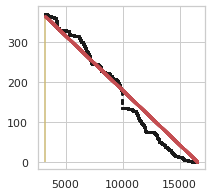

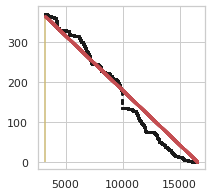

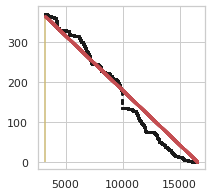

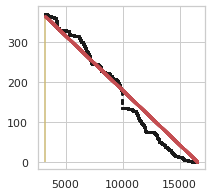

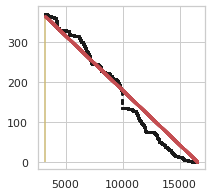

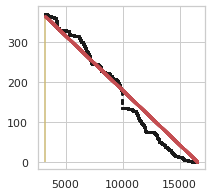

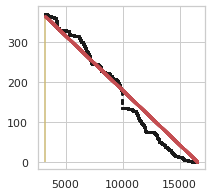

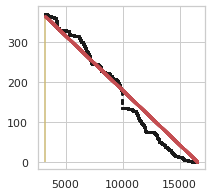

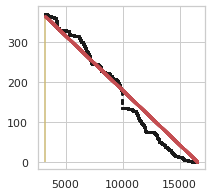

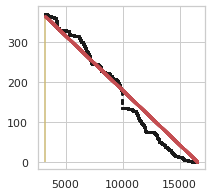

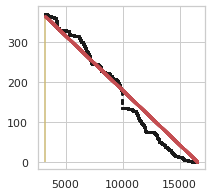

In [48]:
for g in genes_of_interest:
    rna_nascent_fit = rna_nascent_model(out[g+para2] ,None, [out[g+para1], model_loc_length])

    sns.set(style="whitegrid", color_codes=True,font_scale=1)
    f, ax = plt.subplots(figsize=(3, 3))          

    ax.errorbar(x=np.asarray(range(model_loc_start,model_loc_start+model_loc_length)), 
                y=rna_nascent[model_loc_start:], 
                fmt='o', ms=2,color='k') 
    ax.errorbar(x=np.asarray(range(model_loc_start,model_loc_start+model_loc_length)), 
                y=rna_nascent_fit, 
                fmt='o', ms=1,color='r') 

    plt.vlines(model_loc_start,ymin=0,ymax=max(rna_nascent[model_loc_start:]), color='y')
#     plt.vlines(rnr2_3end,ymin=0,ymax=max(rna_nascent))

#     for g in genes_of_interest:
#         end = max(gtf[gtf['gene_name']==g]['end'].values)
#         plt.vlines(end,ymin=0,ymax=max(rna_nascent), color='g')


    filename = 'Fig1K_elongation_rate_fit_F_from_gene_'+g+'.'
    # plt.savefig(os.path.join(path,filename+'tiff'), bbox_inches="tight", transparent=True, dpi=300)
    plt.savefig(os.path.join(path,filename+'pdf'), bbox_inches="tight", transparent=True)
    # plt.savefig(os.path.join(path,filename+'png'), bbox_inches="tight", transparent=True, dpi=300) 

# Plot main figure 1K: Nanopore RNA + model predictions

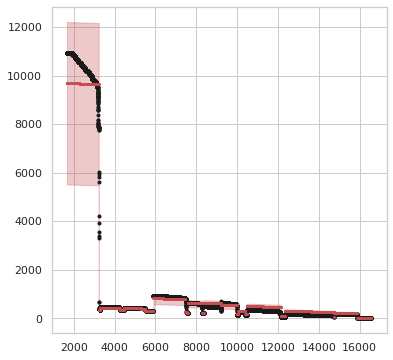

In [6]:
g_av = 'MT-RNR2'
plot_start = gtf[gtf['gene_name']==g_av]['start'].values[0] #TSS location set at 0

F_av = out[g_av + para1]
F_min = min(out[para1])
F_max = max(out[para1])
v_av = out[g_av + para2]
v_min = min(out[para2])
v_max = max(out[para2])

rna_nascent_fit_av = rna_nascent_model(v_av ,None, [F_av, (genome_len-plot_start)])
rna_pred_av = rna_model(rna_nascent_fit_av, F_av, plot_start)
rna_nascent_fit_min = rna_nascent_model(v_min ,None, [F_min, (genome_len-plot_start)])
rna_pred_min = rna_model(rna_nascent_fit_min, F_min, plot_start)
rna_nascent_fit_max = rna_nascent_model(v_max ,None, [F_max, (genome_len-plot_start)])
rna_pred_max = rna_model(rna_nascent_fit_max, F_max, plot_start)
    
sns.set(style="whitegrid", color_codes=True,font_scale=1)
f, ax = plt.subplots(figsize=(6, 6))          

ax.errorbar(x=np.asarray(range(plot_start,genome_len)), 
            y=rna[plot_start:], 
            fmt='o', ms=3,color='k')

ax.errorbar(x=np.asarray(range(plot_start,genome_len)), 
            y=rna_pred_av,
#             yerr=[rna_pred_max - rna_pred_av,
#                   rna_pred_av - rna_pred_min],                
            fmt='o', ms=1,color='r') 

plt.fill_between(np.asarray(range(plot_start,genome_len)), 
                 rna_pred_min, rna_pred_max, 
                 color='r',alpha=0.3)
    
     
    
filename = 'Fig1K_Nanopore_RNA_model_prediction.'
# plt.savefig(os.path.join(path,filename+'pdf'), bbox_inches="tight", transparent=True)
# plt.savefig(os.path.join(path,filename+'tiff'), bbox_inches="tight", transparent=True, dpi=300)
# plt.savefig(os.path.join(path,filename+'png'), bbox_inches="tight", transparent=True, dpi=300) 


#### Possibly show as supplement figure: 1K but with log scale

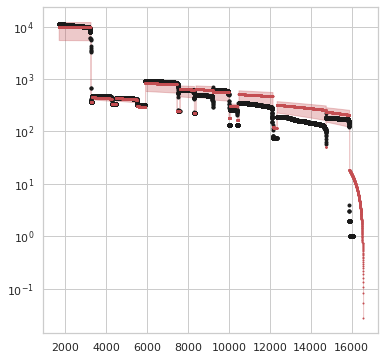

In [7]:

sns.set(style="whitegrid", color_codes=True,font_scale=1)
f, ax = plt.subplots(figsize=(6, 6))          

ax.errorbar(x=np.asarray(range(plot_start,genome_len)), 
            y=rna[plot_start:], 
            fmt='o', ms=3,color='k')

ax.errorbar(x=np.asarray(range(plot_start,genome_len)), 
            y=rna_pred_av,
#             yerr=[rna_pred_max - rna_pred_av,
#                   rna_pred_av - rna_pred_min],                
            fmt='o', ms=1,color='r') 

plt.fill_between(np.asarray(range(plot_start,genome_len)), 
                 rna_pred_min, rna_pred_max, 
                 color='r',alpha=0.3)
    
plt.yscale('log') 
    
filename = 'Fig1K_Nanopore_RNA_model_prediction_logscale.'
plt.savefig(os.path.join(path,filename+'pdf'), bbox_inches="tight", transparent=True)

#### DO NOT SHOW: Individual RNA model predictions using different firing rates

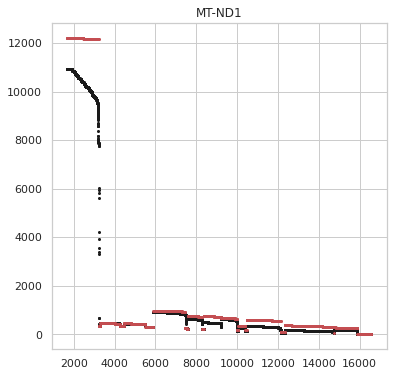

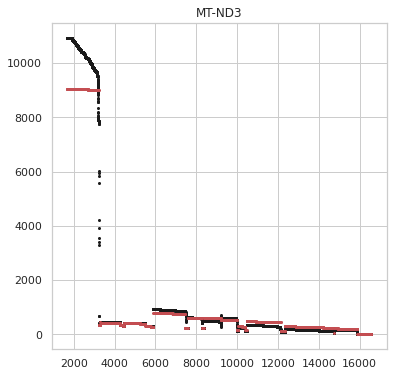

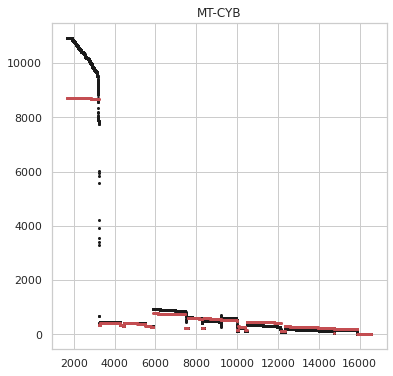

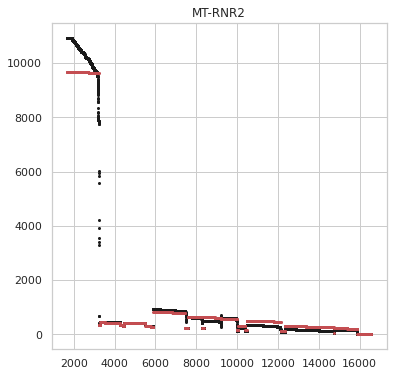

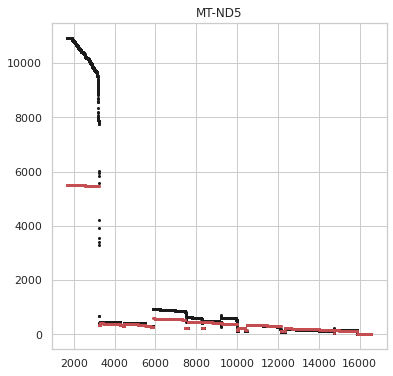

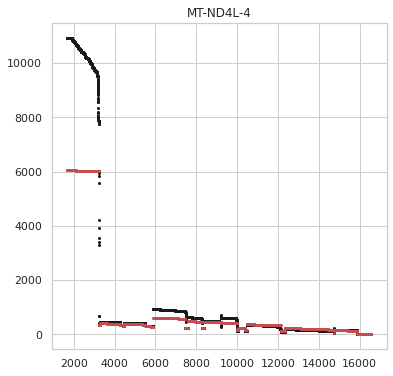

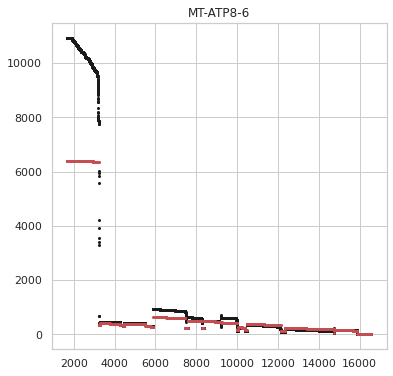

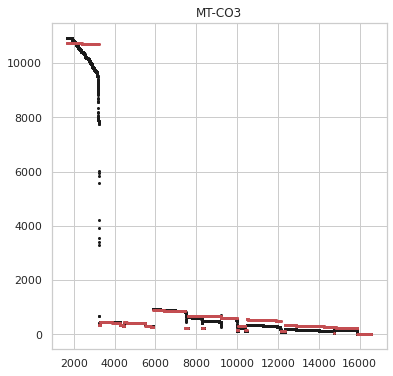

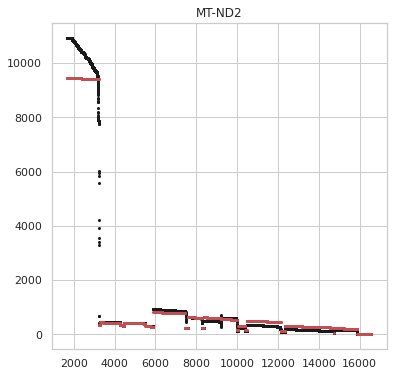

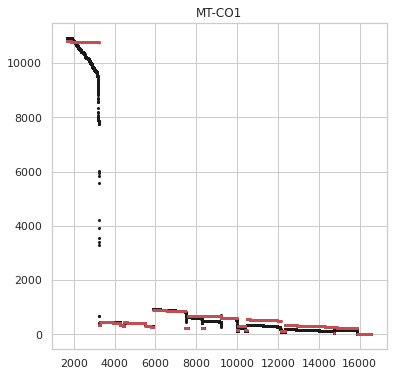

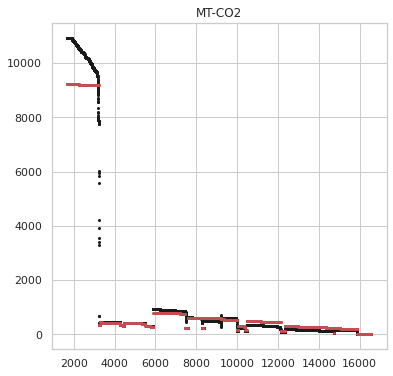

In [46]:
plot_start = gtf[gtf['gene_name']=='MT-RNR2']['start'].values[0] #TSS location set at 0

for g in genes_of_interest:
    rna_nascent_fit = rna_nascent_model(out[g+para2] ,None, [out[g+para1], (genome_len-plot_start)])
    rna_prediction = rna_model(rna_nascent_fit, out[g+para1], plot_start)
    
    sns.set(style="whitegrid", color_codes=True,font_scale=1)
    f, ax = plt.subplots(figsize=(6, 6))          

    ax.errorbar(x=np.asarray(range(plot_start,genome_len)), 
                y=rna[plot_start:], 
                fmt='o', ms=2,color='k') 
    ax.errorbar(x=np.asarray(range(plot_start,genome_len)), 
                y=rna_prediction, 
                fmt='o', ms=1,color='r') 

#     plt.vlines(model_loc_start,ymin=0,ymax=max(rna_nascent[model_loc_start:]), color='y')
#     plt.vlines(rnr2_3end,ymin=0,ymax=max(rna_nascent))

#     for g in genes_of_interest:
#         end = max(gtf[gtf['gene_name']==g]['end'].values)
#         plt.vlines(end,ymin=0,ymax=max(rna_nascent), color='g')

    plt.title(g) 
    
filename = 'Fig1K_Nanopore_RNA_model_prediction_F_from_gene_'+g+'.'
# plt.savefig(os.path.join(path,filename+'tiff'), bbox_inches="tight", transparent=True, dpi=300)
plt.savefig(os.path.join(path,filename+'pdf'), bbox_inches="tight", transparent=True)
# plt.savefig(os.path.join(path,filename+'png'), bbox_inches="tight", transparent=True, dpi=300) 


# sns.set(style="whitegrid", color_codes=True,font_scale=1)
# f, ax = plt.subplots(figsize=(6, 6))          

# ax.errorbar(x=gen_loc, y=rna, 
#             fmt='o', ms=5,color='k') 

# ax.errorbar(x=gen_loc, y=rna_model, 
#             fmt='o', ms=2,color='r') 


# plt.vlines(rnr2_3end,ymin=0,ymax=max(rna))

# plt.vlines(model_start,ymin=0,ymax=max(rna), color='y')

### Trial: Generate model predicted RNA
Assumption Pol II elongates across whole genome and does not drop off

## Problems / solutions
- nascent RNA : two slopes (one for RNR1/2 and one for the rest) inconsistent with one TSS / firing / elongation rate

Solution: we leave RNR1/2 unexplained

- the literature elongation rate seems no longer correct: the red model undershoots the data systematically

This is fine, we just the elongation rate and present that.

In [66]:
#Firing rate F not known in absolute terms, use RNR2 or ND1 to estimate from 
#observed Nanopore + degradation rate
rd = 'mean' 
g = 'MT-RNR2' 
rnr2_3end = gtf[gtf['gene_name']==g]['end'].values[0]
model_start = gtf[gtf['gene_name']==g]['start'].values[0]
print(g,'3\'end', rnr2_3end)

F = rna_mature[g] * deg_rate[rd][deg_rate[rd]['symbol']==g]['k'].values[0] #Transcriptional Firing rate
print('Relative firing rate (min^-1), fitted using gene ',g, ': ',F)
#wil be used to scale model to observed RNA which are all relative values.

velo = 0.1e3 #3.81 * 60 #3.81 ± 0.37 nt/s converted to nt/min,  literature value

rna_model = np.zeros(genome_len)
for x in range(model_start,genome_len):
    rna_model[x] += F * (genome_len - x) / velo
rna_nascent_model = copy.deepcopy(rna_model)
    
for idx in deg_rate[rd].index:
    g = deg_rate[rd]['symbol'][idx]
    if g in genes_of_interest:
        deg = deg_rate[rd]['k'][idx]
        g_info = gtf[gtf['gene_name']==g]
        if len(g_info) > 0:
            g5p = g_info['start'].values[0]
            g3p = g_info['end'].values[0]
            print(g, g5p, g3p)

            rna_model[g5p:g3p] += F / deg
            print(F, deg, F/deg)

MT-RNR2 3'end 3228
Relative firing rate (min^-1), fitted using gene  MT-RNR2 :  2.6355032810016423
MT-RNR2 1671 3228
2.6355032810016423 0.0002839370050637408 9282.0
MT-ND1 3304 4261
2.6355032810016423 0.030453184207352556 86.54278196515594
MT-ND3 10058 10403
2.6355032810016423 0.020142095254164435 130.8455375543289
MT-ND4L-4 10469 12136
2.6355032810016423 0.0075695983599812265 348.16950063492914
MT-CO2 7585 8290
2.6355032810016423 0.006577930379498197 400.65843342092256
MT-ATP8-6 8364 9206
2.6355032810016423 0.00631660042774702 417.23444614679596
MT-CO3 9206 9989
2.6355032810016423 0.007041983821962887 374.25579888182995
MT-ND2 4469 5510
2.6355032810016423 0.02544590859877919 103.57277166074884
MT-CO1 5900 7444
2.6355032810016423 0.004833730752252595 545.231709435503
MT-ND5 12336 14740
2.6355032810016423 0.01273051747781674 207.02247851228952
MT-CYB 14746 15886
2.6355032810016423 0.013989345080043271 188.3936142772947


## Plot nanopore RNA

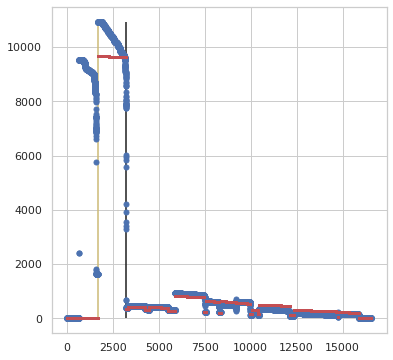

In [68]:
sns.set(style="whitegrid", color_codes=True,font_scale=1)
f, ax = plt.subplots(figsize=(6, 6))          

ax.errorbar(x=gen_loc, y=rna, 
            fmt='o', ms=5,color='k') 

ax.errorbar(x=gen_loc, y=rna_model, 
            fmt='o', ms=2,color='r') 


plt.vlines(rnr2_3end,ymin=0,ymax=max(rna))

plt.vlines(model_start,ymin=0,ymax=max(rna), color='y')

### Fit range of possible elongation rates
"Nascent" RNA:= total RNA - 3' mapping RNA

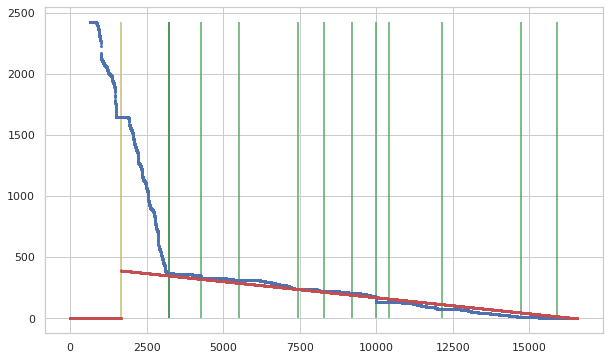

In [69]:
sns.set(style="whitegrid", color_codes=True,font_scale=1)
f, ax = plt.subplots(figsize=(10, 6))          

ax.errorbar(x=gen_loc, y=rna_nascent, 
            fmt='o', ms=2,color='k') 
ax.errorbar(x=gen_loc, y=rna_nascent_model, 
            fmt='o', ms=1,color='r') 

plt.vlines(model_start,ymin=0,ymax=max(rna_nascent), color='y')
plt.vlines(rnr2_3end,ymin=0,ymax=max(rna_nascent))

for g in genes_of_interest:
    end = max(gtf[gtf['gene_name']==g]['end'].values)
    plt.vlines(end,ymin=0,ymax=max(rna_nascent), color='g')

## Inspect RNR2 3' region for amount of transcripts mapping 3' there

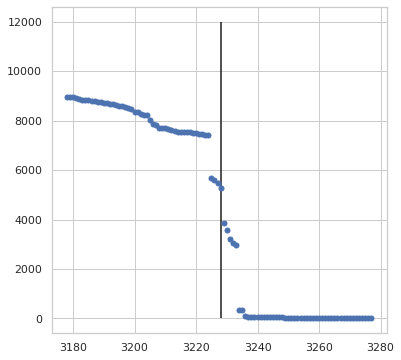

In [25]:
sns.set(style="whitegrid", color_codes=True,font_scale=1)
f, ax = plt.subplots(figsize=(6, 6))          

ax.errorbar(x=gen_loc[(rnr2_3end-window_3p):(rnr2_3end+window_3p)], 
            y=rna[(rnr2_3end-window_3p):(rnr2_3end+window_3p)], 
            fmt='o', ms=5,color='b') 

# ax.errorbar(x=gen_loc, y=rna_model, 
#             fmt='o', ms=2,color='r') 


plt.vlines(rnr2_3end,ymin=0,ymax=1.2e4)

# plt.vlines(model_start,ymin=0,ymax=1.2e4, color='y')

In [30]:
genome_len = max(max(nano['merge']['end']), max(gtf['end']))
window_3p = 50 #100 #
TSS = gtf[gtf['gene_id']=='HSP2']['end'].values[0]
gen_loc = np.arange(genome_len)
rna = np.zeros(genome_len) #plus strand only
rna_nascent = np.zeros(genome_len) #plus strand only

rna_mature = dict()
for g in deg_rate['mean']['symbol']:
    rna_mature[g] = 0

for idx in nano['merge'].index:#[nano['merge']['strand']=='+'].index:#[:1] #45seconds
    if nano['merge']['strand'][idx] == '+':
        end = nano['merge']['end'][idx]
        read_id = nano['merge']['name'][idx]#get read id.
        g_info = genes['merge'][genes['merge']['read']==read_id]
        if len(g_info) > 0:
            mapping_genes = g_info['gene_names'].values[0]#get the gene(s) the read maps to:
            mapping_genes = set(mapping_genes.split(','))
            gene_oi = mapping_genes.intersection(genes_of_interest)
    #             if gene_oi:
    #                 print(gene_oi)
            nascent = True
            for g in gene_oi:
                g_info = gtf[gtf['gene_name']==g]
                g5p = TSS#g_info['start'].values[0]
                g3p = g_info['end'].values[0]
    #                 print(g, g5p, g3p, end)

#                 if (abs(g3p - end) <= window_3p) & (len(gene_oi)==1):#mature RNA
                rna[g5p:(end+1)] += 1 #add coverage only over that gene:
                rna_mature[g] += 1
                nascent = False
#                     continue
                    
            if nascent: #nascent RNA:
                rna[TSS:(end+1)] += 1
                rna_nascent[TSS:(end+1)] += 1

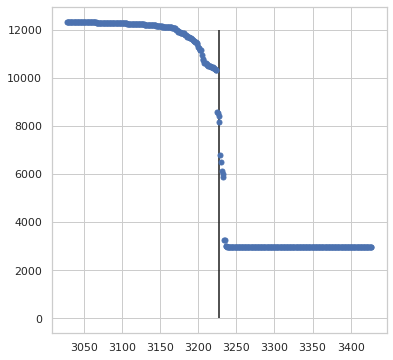

In [31]:
window_3p = 200 #

sns.set(style="whitegrid", color_codes=True,font_scale=1)
f, ax = plt.subplots(figsize=(6, 6))          

ax.errorbar(x=gen_loc[(rnr2_3end-window_3p):(rnr2_3end+window_3p)], 
            y=rna[(rnr2_3end-window_3p):(rnr2_3end+window_3p)], 
            fmt='o', ms=5,color='b') 

# ax.errorbar(x=gen_loc, y=rna_model, 
#             fmt='o', ms=2,color='r') 


plt.vlines(rnr2_3end,ymin=0,ymax=1.2e4)

# plt.vlines(model_start,ymin=0,ymax=1.2e4, color='y')

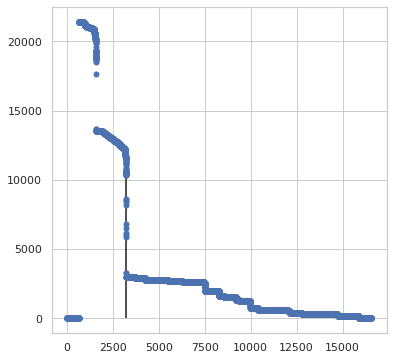

In [32]:
sns.set(style="whitegrid", color_codes=True,font_scale=1)
f, ax = plt.subplots(figsize=(6, 6))          

ax.errorbar(x=gen_loc, 
            y=rna, 
            fmt='o', ms=5,color='b') 

# ax.errorbar(x=gen_loc, y=rna_model, 
#             fmt='o', ms=2,color='r') 


plt.vlines(rnr2_3end,ymin=0,ymax=1.2e4)

# plt.vlines(model_start,ymin=0,ymax=1.2e4, color='y')

## OLD

In [33]:
!pip freeze

asteval==0.9.23
attrs==19.3.0
backcall==0.1.0
backports.zoneinfo==0.2.1
bleach==3.1.4
certifi==2021.5.30
cffi==1.15.0
charset-normalizer==2.0.1
cycler==0.10.0
decorator==4.4.2
defusedxml==0.6.0
docopt==0.6.2
entrypoints==0.3
future==0.18.2
goatools==1.1.6
gtfparse==1.2.1
idna==3.2
importlib-metadata==1.5.2
ipykernel==5.2.0
ipython==7.13.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
jedi==0.16.0
Jinja2==2.11.1
joblib==1.1.0
jsonschema==3.2.0
jupyter==1.0.0
jupyter-client==6.1.2
jupyter-console==6.1.0
jupyter-core==4.6.3
kiwisolver==1.1.0
llvmlite==0.36.0
lmfit==1.0.2
MarkupSafe==1.1.1
matplotlib==3.2.1
mistune==0.8.4
mpmath==1.2.1
nbconvert==5.6.1
nbformat==5.0.4
networkx==2.4
notebook==6.0.3
numba==0.53.1
numba-scipy==0.3.0
numpy==1.16.5
pandas==1.0.3
pandocfilters==1.4.2
parso==0.6.2
patsy==0.5.2
pexpect==4.8.0
pickleshare==0.7.5
Pillow==7.0.0
prometheus-client==0.7.1
prompt-toolkit==3.0.4
ptyprocess==0.6.0
pycparser==2.21
pydot==1.4.2
Pygments==2.6.1
pyparsing==2.4.6
pyrsistent==0.16.0

In [49]:
fit_start = gtf[gtf['gene_name']=='MT-RNR1']['start'].values[0]
fit_end = max(gtf[gtf['gene_name']=='MT-RNR2']['end'].values)
print('RNRs range',fit_start, fit_end)
gen_loc_rnrs = gen_loc[fit_start:fit_end]

res_rnrs = linregress(gen_loc_rnrs, nrna[fit_start:fit_end])
print(res_rnrs)
fit_rnrs = res_rnrs.slope * gen_loc_rnrs + res_rnrs.intercept

fit_start = max(gtf[gtf['gene_name']=='MT-RNR2']['end'].values)
fit_end = max(gtf[gtf['gene_name'].isin(genes_of_interest)]['end'].values)
print('mRNAs range',fit_start, fit_end)
gen_loc_mrna = gen_loc[fit_start:fit_end]

res_mrna = linregress(gen_loc_mrna, nrna[fit_start:fit_end])
print(res_mrna)
fit_mrna = res_mrna.slope * gen_loc_mrna + res_mrna.intercept


RNRs range 648 3228
LinregressResult(slope=-0.6814841090295917, intercept=2497.137089151811, rvalue=-0.9919585865613896, pvalue=0.0, stderr=0.0017124862138020811, intercept_stderr=3.554638851091479)
mRNAs range 3228 15886
LinregressResult(slope=-0.022796202646332073, intercept=352.8312122171018, rvalue=-0.9963484331778347, pvalue=0.0, stderr=1.736444198385148e-05, intercept_stderr=0.17766019817915182)


In [74]:
velo_rnrs = F / abs(res_rnrs.slope) #nt/s
print(velo_rnrs, 'nt/s', velo_rnrs * 60 / 1000, 'kb/min')

24.301784623798966 nt/s 1.4581070774279379 kb/min


In [75]:
velo_mrna = F / abs(res_mrna.slope) #nt/s
print(velo_mrna, 'nt/s', velo_mrna * 60 / 1000, 'kb/min')

726.4929295074236 nt/s 43.589575770445414 kb/min


<ErrorbarContainer object of 3 artists>

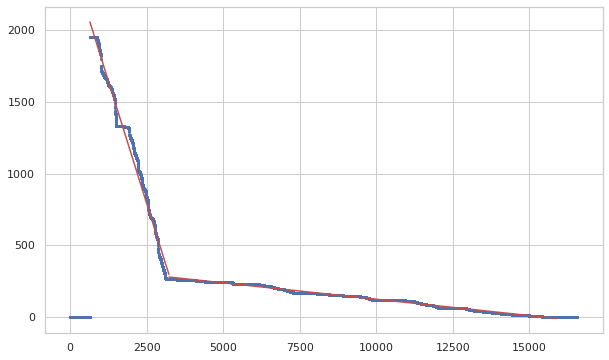

In [53]:
sns.set(style="whitegrid", color_codes=True,font_scale=1)
f, ax = plt.subplots(figsize=(10, 6))          

ax.errorbar(x=gen_loc, y=nrna, 
            fmt='o', ms=2,color='b') 

ax.errorbar(x=gen_loc_rnrs, y=fit_rnrs, 
            fmt='-', ms=1,color='r')

ax.errorbar(x=gen_loc_mrna, y=fit_mrna, 
            fmt='-', ms=1,color='r')

## Testing effect of assumed mRNA region specific transcription initiation rate

In [90]:
#Firing rate F not known in absolute terms, use MT-CYB to estimate from 
#observed Nanopore + degradation rate
rep = 'average' #'rep1_50uM'#
g = 'MT-CYB'#

end = gtf[gtf['gene_name']==g]['end'].values[0]
print(g,'3\'end', end)

F_mrna = rna[(end-window_3p)] * deg_rate[deg_rate['symbol']==g][rep].values[0] 
print('Relative firing rate (min^-1), fitted using gene ',g, ': ',F_mrna)
#wil be used to scale model to observed RNA which are all relative values.


MT-CYB 3'end 15886
Relative firing rate (min^-1), fitted using gene  MT-CYB :  3.8574591249225185


In [91]:
velo_mrna = F_mrna / abs(res_mrna.slope) #nt/s
print(velo_mrna, 'nt/s', velo_mrna * 60 / 1000, 'kb/min')

169.2149865821265 nt/s 10.15289919492759 kb/min


In [28]:
# nrna = np.zeros(genome_len) #plus strand only

# window_3p = 100

# for idx in nano['merge'].index:#[:1]:
#     if nano3prime['strand'][idx] == '+':
#         end = nano['merge']['end'][idx]
#         read_id = nano['merge']['name'][idx]#get read id.
#         g_info = genes[genes['read']==read_id]
#         if len(g_info) > 0:
#             mapping_genes = g_info['gene_names'].values[0]#get the gene(s) the read maps to:
#             mapping_genes = set(mapping_genes.split(','))
#             gene_oi = mapping_genes.intersection(genes_of_interest)
#             nascent = True
#             for g in gene_oi:
#                 g_info = gtf[gtf['gene_name']==g]
#                 g5p = max(g_info['start'].values)
#                 g3p = max(g_info['end'].values)
                
#                 if abs(g3p - end) <= window_3p:#mature RNA
#                     nascent = False
#                     continue
#             if nascent: #nascent RNA:
#                 nrna[TSS:(end+1)] += 1